In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sns

In [3]:
transform=transforms.Compose(
    [transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))]
)

In [6]:
batch_size = 4
trainset = torchvision.datasets.ImageFolder(root='dataset/binary_cls/data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.ImageFolder(root='dataset/binary_cls/data/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
classes=['positive', 'negative']

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

get some random training images

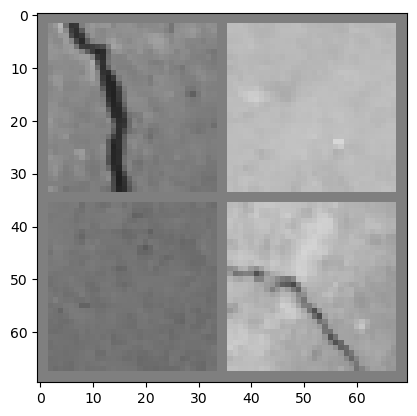

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.__next__()
imshow(torchvision.utils.make_grid(images, nrow=2))

In [16]:
images.shape

torch.Size([4, 1, 32, 32])

Neural Network setup

In [18]:
class ImageClassificationNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2=nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.fc1=nn.Linear(in_features=16*6*6, out_features=120)
        self.fc2=nn.Linear(in_features=120, out_features=84)
        self.fc3=nn.Linear(in_features=84, out_features=1)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)
        x=torch.flatten(x, 1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        x=self.sigmoid(x)
        return x
        
        

init model

In [19]:
model=ImageClassificationNet()
loss_fn=nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

Training

In [20]:
losses=[]
Num_Epochs=100
for epoch in range(Num_Epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.reshape(-1, 1).float())
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{Num_Epochs}, Step {i+1}/{len(trainloader)}, Loss: {loss.item():.4f}')
        

Epoch 0/100, Step 250/250, Loss: 0.0146
Epoch 10/100, Step 250/250, Loss: 0.0001
Epoch 20/100, Step 250/250, Loss: 0.0001
Epoch 30/100, Step 250/250, Loss: 0.0000
Epoch 40/100, Step 250/250, Loss: 0.0000
Epoch 50/100, Step 250/250, Loss: 0.0000
Epoch 60/100, Step 250/250, Loss: 0.0000
Epoch 70/100, Step 250/250, Loss: 0.0007
Epoch 80/100, Step 250/250, Loss: 0.0163
Epoch 90/100, Step 250/250, Loss: 0.0019


Evaluation

<Axes: >

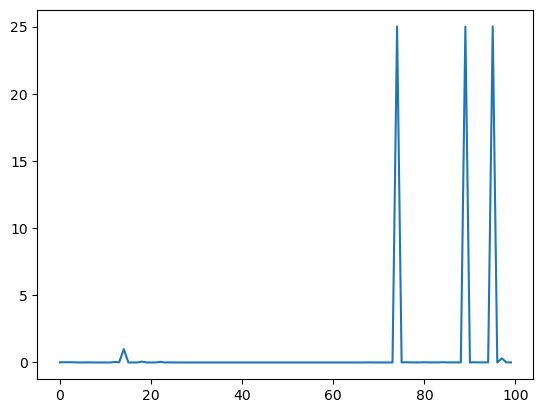

In [22]:
sns.lineplot(x=range(len(losses)), y=losses)

test

In [29]:
y_test = []
y_test_hat = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()
    
    y_test.extend(y_test_temp.numpy())
    y_test_hat.extend(y_test_hat_temp.numpy())

In [30]:
acc = accuracy_score(y_test, y_test_hat)
print(f'Accuracy: {acc*100:.2f} %')

Accuracy: 97.33 %


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, and F1-score for classification
precision = precision_score(y_test, y_test_hat)
recall = recall_score(y_test, y_test_hat)
f1 = f1_score(y_test, y_test_hat)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Precision: 99.31%
Recall: 95.33%
F1-Score: 97.28%


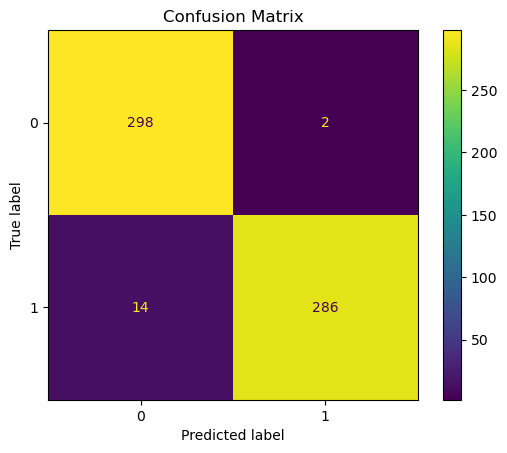

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_test_hat_list=[y_hat.item() for i,y_hat in enumerate(y_test_hat)]
# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat_list)
plt.title('Confusion Matrix')
plt.show()

Model Save

In [41]:
torch.save(model.state_dict(), 'artifacts/cnn_binary_classification.pth')

In [49]:
model_loaded = ImageClassificationNet()
model_loaded.load_state_dict(torch.load('artifacts/cnn_binary_classification.pth'))
model_loaded.eval()

ImageClassificationNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [51]:
from PIL import Image
# Load and preprocess the image
img_path = 'dataset/binary_cls/data/test/Negative/00501.jpg'
img = Image.open(img_path)
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

In [54]:

with torch.no_grad():
    result = model_loaded(img_tensor).round()
    if result.item() == 0:
        print('Negative')
    else:
        print('Positive')
    

0.0
Negative
